## **Notebook EC#05**
## Credit risk solution with logistic regression + performance criteria tour.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Túlio Queiroz de Paula


#### **With this notebook, you will learn how to synthesize and analyze a binary classifier for credit risk using logistic regression.**
#### **Please refer to the lecture notes (provided as supporting material) to better familiarize yourself with the concept of logistic regression.**
#### **Please, make the upload of the dataset [german_credit_data_with_risk.csv] before executing the code.**
Partially based on [this content](https://www.kaggle.com/code/hishamyhjuneidi/german-credit-risk-analysis-and-modeling) and [this content](https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Random%20Forest%20Explained.ipynb).

Due to compatibility issues, it was necessary to perform a downgrade operation over Scipy.

In [2]:
!pip uninstall scipy
# Please, press [Y].

Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scipy-1.13.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so
    /usr/local/lib/python3.10/dist-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/scipy/*
Proceed (Y/n)? Y
  Successfully uninstalled scipy-1.13.1


In [2]:
!pip install scipy==1.9.0

In [55]:
# Load the main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Data Acquisition**

In [56]:
# Pandas is used for data manipulation
import pandas as pd

# Reading data as pandas dataframe
features = pd.read_csv('german_credit_data_with_risk.csv')

### **Looking inside the dataset**

In [57]:
print('The size of the dataset is:', features.shape)

The size of the dataset is: (1000, 11)


In [58]:
pd.set_option('display.max_columns', None)
features.head(5)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [59]:
# Eliminating spaces in some feature names
features.rename(columns = {'Saving accounts':'Saving_accounts', 'Checking account':'Checking_account', 'Credit amount':'Credit_amount'}, inplace = True)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving_accounts   817 non-null    object
 6   Checking_account  606 non-null    object
 7   Credit_amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [60]:
# Quantity of missing values per feature
features.isna().sum()

,0
Unnamed: 0,0
Age,0
Sex,0
Job,0
Housing,0
Saving_accounts,183
Checking_account,394
Credit_amount,0
Duration,0
Purpose,0


These missing values will be kept as is, because one-hot encoding will use all zeros for Saving_accounts and Checking_account in these cases.

In [61]:
# Descriptive statistics for each numerical feature
features.describe()

,Unnamed: 0,Age,Job,Credit_amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [62]:
# Value counting for two numerical and five categorical features
print(features.Sex.value_counts())
print(features.Job.value_counts())
print(features.Housing.value_counts())
print(features.Saving_accounts.value_counts())
print(features.Checking_account.value_counts())
print(features.Purpose.value_counts())
print(features.Risk.value_counts())

Sex
male      690
female    310
Name: count, dtype: int64
Job
2    630
1    200
3    148
0     22
Name: count, dtype: int64
Housing
own     713
rent    179
free    108
Name: count, dtype: int64
Saving_accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64
Checking_account
little      274
moderate    269
rich         63
Name: count, dtype: int64
Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64
Risk
good    700
bad     300
Name: count, dtype: int64


### **Data preparation**

#### **One-Hot Encoding**

One hot encoding takes this:

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

and converts it into:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

NaN values will be all zeros.

In [63]:
# One-hot encode categorical features
features = pd.get_dummies(features)
pd.set_option('display.max_columns', None)
features.head(5)

,Unnamed: 0,Age,Job,Credit_amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving_accounts_little,Saving_accounts_moderate,Saving_accounts_quite rich,Saving_accounts_rich,Checking_account_little,Checking_account_moderate,Checking_account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_bad,Risk_good
0,0,67,2,1169,6,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
1,1,22,2,5951,48,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False
2,2,49,1,2096,12,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,3,45,2,7882,42,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
4,4,53,2,4870,24,False,True,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False


In [64]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (1000, 27)


#### **Split features and labels, and convert data to arrays**

The first column will be eliminated and the desired classification will be associated with the last colum: Risk_good.

In [65]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['Risk_good'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['Unnamed: 0', 'Risk_good', 'Risk_bad'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

print('Final shape of features:', features.shape)

Final shape of features: (1000, 24)


In [66]:
features.head(5)

,Age,Job,Credit_amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving_accounts_little,Saving_accounts_moderate,Saving_accounts_quite rich,Saving_accounts_rich,Checking_account_little,Checking_account_moderate,Checking_account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
1,22,2,5951,48,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False
2,49,1,2096,12,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,45,2,7882,42,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False
4,53,2,4870,24,False,True,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False


In [67]:
# Convert to numpy array
features = np.array(features)

#### **Training and Testing Sets**

In [68]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [69]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (750, 24)
Training Labels Shape: (750,)
Testing Features Shape: (250, 24)
Testing Labels Shape: (250,)


(array([228.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 522.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

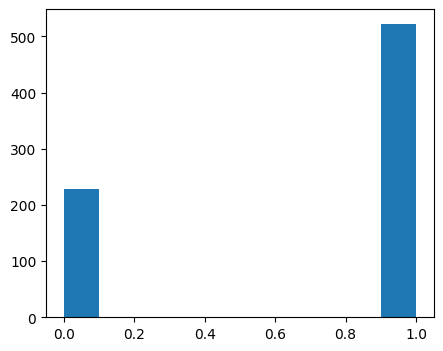

In [70]:
plt.figure(figsize=(5,4))
plt.hist(y_train.astype(int))

(array([ 72.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 178.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

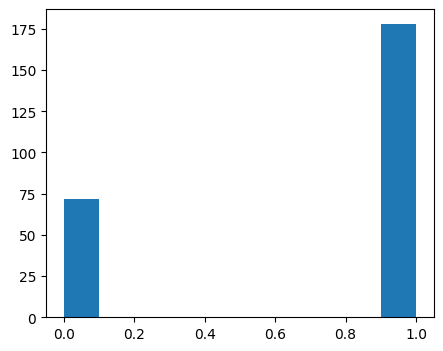

In [71]:
plt.figure(figsize=(5,4))
plt.hist(y_test.astype(int))

#### **An attempt to define the best class weights using accuracy as the performance criterion.**

In [72]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# define grid
balance  = [{0:5,1:1}, {0:7/3,1:1}, {0:1.5,1:1}, {0:1,1:1}, {0:1,1:1.5}, {0:1,1:7/3}, {0:1,1:5}]
c_values = [0.01, 0.01, 1, 10, 100] ## extra evaluation. crude search
param_grid = {'class_weight' : balance,
              'C'            : c_values} ## extra evaluation, original assignment evaluates only 'class_weight'

# define model
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter = 1000)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.739111 using {'C': 100, 'class_weight': {0: 1, 1: 1}}
0.475556 (0.043319) with: {'C': 0.01, 'class_weight': {0: 5, 1: 1}}
0.671111 (0.042907) with: {'C': 0.01, 'class_weight': {0: 2.3333333333333335, 1: 1}}
0.733333 (0.043682) with: {'C': 0.01, 'class_weight': {0: 1.5, 1: 1}}
0.711556 (0.030304) with: {'C': 0.01, 'class_weight': {0: 1, 1: 1}}
0.699111 (0.024750) with: {'C': 0.01, 'class_weight': {0: 1, 1: 1.5}}
0.700444 (0.010740) with: {'C': 0.01, 'class_weight': {0: 1, 1: 2.3333333333333335}}
0.696000 (0.005333) with: {'C': 0.01, 'class_weight': {0: 1, 1: 5}}
0.475556 (0.043319) with: {'C': 0.01, 'class_weight': {0: 5, 1: 1}}
0.671111 (0.042907) with: {'C': 0.01, 'class_weight': {0: 2.3333333333333335, 1: 1}}
0.733333 (0.043682) with: {'C': 0.01, 'class_weight': {0: 1.5, 1: 1}}
0.711556 (0.030304) with: {'C': 0.01, 'class_weight': {0: 1, 1: 1}}
0.699111 (0.024750) with: {'C': 0.01, 'class_weight': {0: 1, 1: 1.5}}
0.700444 (0.010740) with: {'C': 0.01, 'class_weight': {0: 1, 1:

In [73]:
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.167833,0.064786,0.006114,0.006107,0.01,"{0: 5, 1: 1}","{'C': 0.01, 'class_weight': {0: 5, 1: 1}}",0.480000,0.400000,0.493333,0.493333,0.520000,0.440000,0.493333,0.480000,0.480000,0.440000,0.493333,0.426667,0.506667,0.466667,0.560000,0.520000,0.413333,0.493333,0.413333,0.533333,0.520000,0.440000,0.440000,0.426667,0.573333,0.480000,0.493333,0.466667,0.413333,0.466667,0.475556,0.043319,34
1,0.092489,0.038525,0.003912,0.003725,0.01,"{0: 2.3333333333333335, 1: 1}","{'C': 0.01, 'class_weight': {0: 2.333333333333...",0.586667,0.600000,0.693333,0.706667,0.720000,0.640000,0.666667,0.693333,0.666667,0.733333,0.720000,0.653333,0.586667,0.653333,0.706667,0.680000,0.613333,0.706667,0.613333,0.733333,0.666667,0.653333,0.626667,0.680000,0.640000,0.693333,0.733333,0.680000,0.720000,0.666667,0.671111,0.042907,29
2,0.060898,0.025661,0.002926,0.002557,0.01,"{0: 1.5, 1: 1}","{'C': 0.01, 'class_weight': {0: 1.5, 1: 1}}",0.706667,0.720000,0.746667,0.786667,0.720000,0.786667,0.693333,0.773333,0.720000,0.733333,0.733333,0.813333,0.626667,0.733333,0.813333,0.720000,0.746667,0.680000,0.653333,0.706667,0.760000,0.746667,0.693333,0.666667,0.733333,0.760000,0.773333,0.746667,0.786667,0.720000,0.733333,0.043682,4
3,0.076302,0.039430,0.004109,0.004545,0.01,"{0: 1, 1: 1}","{'C': 0.01, 'class_weight': {0: 1, 1: 1}}",0.706667,0.680000,0.746667,0.786667,0.680000,0.706667,0.680000,0.720000,0.693333,0.693333,0.720000,0.720000,0.680000,0.746667,0.733333,0.720000,0.760000,0.653333,0.666667,0.680000,0.760000,0.733333,0.680000,0.693333,0.706667,0.733333,0.733333,0.720000,0.706667,0.706667,0.711556,0.030304,12
4,0.098048,0.069000,0.003205,0.003771,0.01,"{0: 1, 1: 1.5}","{'C': 0.01, 'class_weight': {0: 1, 1: 1.5}}",0.693333,0.720000,0.733333,0.746667,0.680000,0.653333,0.693333,0.693333,0.693333,0.693333,0.720000,0.733333,0.706667,0.733333,0.720000,0.666667,0.693333,0.640000,0.693333,0.666667,0.706667,0.733333,0.693333,0.680000,0.680000,0.720000,0.706667,0.706667,0.693333,0.680000,0.699111,0.024750,19
5,0.065611,0.034758,0.001762,0.000139,0.01,"{0: 1, 1: 2.3333333333333335}","{'C': 0.01, 'class_weight': {0: 1, 1: 2.333333...",0.706667,0.720000,0.693333,0.706667,0.706667,0.693333,0.693333,0.693333,0.693333,0.693333,0.706667,0.706667,0.706667,0.693333,0.706667,0.693333,0.706667,0.680000,0.693333,0.693333,0.706667,0.733333,0.706667,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.720000,0.700444,0.010740,17
6,0.085711,0.049189,0.001798,0.000433,0.01,"{0: 1, 1: 5}","{'C': 0.01, 'class_weight': {0: 1, 1: 5}}",0.706667,0.706667,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.706667,0.706667,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.706667,0.706667,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.693333,0.696000,0.005333,24
7,0.055586,0.019045,0.001852,0.000479,0.01,"{0: 5, 1: 1}","{'C': 0.01, 'class_weight': {0: 5, 1: 1}}",0.480000,0.400000,0.493333,0.493333,0.520000,0.440000,0.493333,0.480000,0.480000,0.440000,0.493333,0.426667,0.506667,0.466667,0.560000,0.520000,0.413333,0.493333,0.413333,0.533333,0.520000,0.440000,0.440000,0.426667,0.573333,0.480000,0.493333,0.466667,0.413333,0.466667,0.475556,0.043319,34
8,0.046802,0.014701,0.001771,0.000241,0.01,"{0: 2.3333333333333335, 1: 1}","{'C': 0.01, 'class_weig

In [74]:
# define grid
balance  = [{0:1.5,1:1}, {0:1,1:1}, {0:1,1:1.5}] ## shortening the range
c_values = [c for c in range(80, 121)] ## extra evaluation. fine search
param_grid = {'class_weight' : balance,
              'C'            : c_values} ## extra evaluation, original assignment evaluates only 'class_weight'

# define model
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter = 1000)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.742222 using {'C': 83, 'class_weight': {0: 1, 1: 1}}
0.725778 (0.033851) with: {'C': 80, 'class_weight': {0: 1.5, 1: 1}}
0.740444 (0.036227) with: {'C': 80, 'class_weight': {0: 1, 1: 1}}
0.727111 (0.038295) with: {'C': 80, 'class_weight': {0: 1, 1: 1.5}}
0.725333 (0.032949) with: {'C': 81, 'class_weight': {0: 1.5, 1: 1}}
0.733778 (0.035857) with: {'C': 81, 'class_weight': {0: 1, 1: 1}}
0.724444 (0.034655) with: {'C': 81, 'class_weight': {0: 1, 1: 1.5}}
0.724889 (0.031455) with: {'C': 82, 'class_weight': {0: 1.5, 1: 1}}
0.736444 (0.034025) with: {'C': 82, 'class_weight': {0: 1, 1: 1}}
0.726222 (0.037196) with: {'C': 82, 'class_weight': {0: 1, 1: 1.5}}
0.726667 (0.034726) with: {'C': 83, 'class_weight': {0: 1.5, 1: 1}}
0.742222 (0.034826) with: {'C': 83, 'class_weight': {0: 1, 1: 1}}
0.727111 (0.039513) with: {'C': 83, 'class_weight': {0: 1, 1: 1.5}}
0.729333 (0.028420) with: {'C': 84, 'class_weight': {0: 1.5, 1: 1}}
0.735111 (0.032611) with: {'C': 84, 'class_weight': {0: 1, 1: 1

#### **Another attempt to define the best class weights using F1-score as the performance criterion.**

In [75]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# define grid
balance2 = [{0:5,1:1}, {0:7/3,1:1}, {0:1.5,1:1}, {0:1,1:1}, {0:1,1:1.5}, {0:1,1:7/3}, {0:1,1:5}]
param_grid2 = dict(class_weight=balance2)

# define model
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter = 1000)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid2 = GridSearchCV(estimator=model, param_grid=param_grid2, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid2_result = grid2.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (grid2_result.best_score_, grid2_result.best_params_))
# report all configurations
means = grid2_result.cv_results_['mean_test_score']
stds = grid2_result.cv_results_['std_test_score']
params = grid2_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.824943 using {'class_weight': {0: 1, 1: 1.5}}
0.571975 (0.065583) with: {'class_weight': {0: 5, 1: 1}}
0.753435 (0.036402) with: {'class_weight': {0: 2.3333333333333335, 1: 1}}
0.800609 (0.027603) with: {'class_weight': {0: 1.5, 1: 1}}
0.823720 (0.025442) with: {'class_weight': {0: 1, 1: 1}}
0.824943 (0.022250) with: {'class_weight': {0: 1, 1: 1.5}}
0.820613 (0.015785) with: {'class_weight': {0: 1, 1: 2.3333333333333335}}
0.821657 (0.006333) with: {'class_weight': {0: 1, 1: 5}}


#### **Build and train the logistic regression learning model**

In [76]:
# Import the model we are using
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Instantiate model
weights = {0: 1, 1: 1}
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter = 1000, class_weight=weights)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the classes on the training data
y_pred = model.predict(X_train)

confusion_matrix(y_train, y_pred)

array([[ 95, 133],
       [ 50, 472]])

In [77]:
model.coef_[0]

array([ 1.86159275e-02,  5.19371853e-03, -1.15129757e-05, -1.29111389e-02,
        8.91381590e-03,  2.01614679e-01, -2.21820330e-01,  3.04991032e-01,
        1.27357793e-01, -2.50932991e-01, -1.41506896e-01,  1.03015887e-01,
        1.44216394e-01, -7.30444717e-01, -6.06413444e-01,  2.13194795e-03,
       -1.06309350e-02,  2.33325938e-02, -3.93693316e-02, -1.53603032e-01,
        2.07151861e-01,  2.77292787e-01, -5.60864221e-02, -3.75590267e-02])

#### **Make predictions on test data (Holdout approach)**

In [78]:
# Use the LR predict method on the test data
y_pred_test = model.predict(X_test)

# Predict the classes on the test data, and return the probabilities for each class
y_proba = model.predict_proba(X_test)


from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_test)

array([[ 25,  47],
       [ 21, 157]])

In [79]:
confusion_matrix(y_test, y_pred_test,normalize='true')

array([[0.34722222, 0.65277778],
       [0.11797753, 0.88202247]])

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_test)

0.728

## Evaluating the binary classifier

#### Means Squared Error (MSE)

In [81]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, y_proba[:,1])

scores = pd.DataFrame({'MSE': [MSE]})
scores

,MSE
0,0.182956


#### Mean Absolute Error (MAE)

In [82]:
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test, y_proba[:,1])
scores_aux = pd.DataFrame({'MAE': [MAE]});
scores = pd.concat([scores, scores_aux], axis=1)
scores

,MSE,MAE
0,0.182956,0.348069


#### Log Loss Function

In [83]:
from sklearn.metrics import log_loss

Log_Loss = log_loss(y_test, y_proba[:,1])
scores_aux = pd.DataFrame({'Log_Loss': [Log_Loss]});
scores = pd.concat([scores, scores_aux], axis=1)
scores

,MSE,MAE,Log_Loss
0,0.182956,0.348069,0.545354


#### Accuracy Score

In [84]:
from sklearn.metrics import accuracy_score

Accuracy_Score = accuracy_score(y_test, y_pred_test)
scores_aux = pd.DataFrame({'Acc': [Accuracy_Score]});
scores = pd.concat([scores, scores_aux], axis=1)
scores

,MSE,MAE,Log_Loss,Acc
0,0.182956,0.348069,0.545354,0.728


In [85]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Precision_Score = precision_score(y_test, y_pred_test)
scores_aux = pd.DataFrame({'Prec': [Precision_Score]});
scores = pd.concat([scores, scores_aux], axis=1)
Recall_Score = recall_score(y_test, y_pred_test)
scores_aux = pd.DataFrame({'Recall': [Recall_Score]});
scores = pd.concat([scores, scores_aux], axis=1)
scores

,MSE,MAE,Log_Loss,Acc,Prec,Recall
0,0.182956,0.348069,0.545354,0.728,0.769608,0.882022


#### F1-score for the positive class

In [86]:
from sklearn.metrics import f1_score

F1_Score = f1_score(y_test, y_pred_test)
scores_aux = pd.DataFrame({'F1': [F1_Score]});
scores = pd.concat([scores, scores_aux], axis=1)
scores

,MSE,MAE,Log_Loss,Acc,Prec,Recall,F1
0,0.182956,0.348069,0.545354,0.728,0.769608,0.882022,0.82199


#### Gain and Lift Charts

In [87]:
!pip install scikit-plot

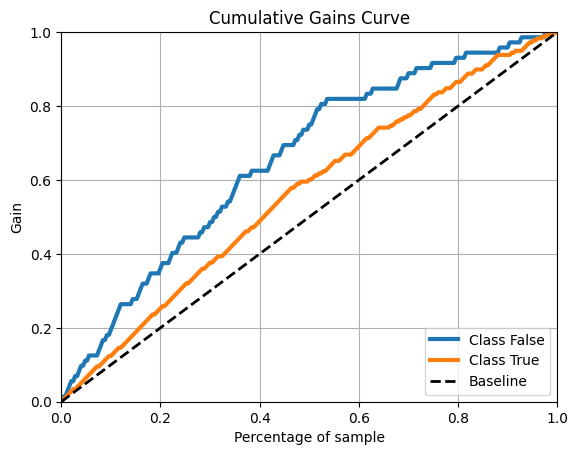

<Figure size 700x500 with 0 Axes>

In [88]:
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.show()

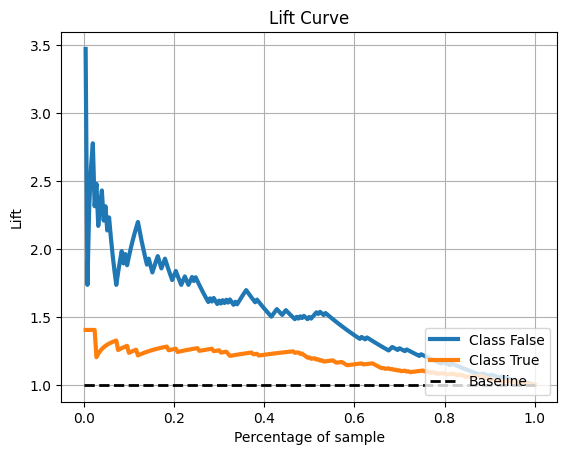

<Figure size 700x500 with 0 Axes>

In [89]:
import scikitplot as skplt

skplt.metrics.plot_lift_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.show()

#### Kolmogorov-Smirnov test

###### A view of the binary classifier output distribution

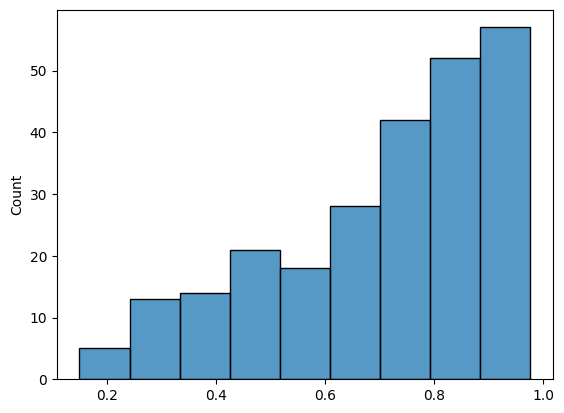

In [90]:
sns.histplot(y_proba[:, 1]);

In [91]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real, y_proba):
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba[:,1]

    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]

    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'] , df['proba'])

    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")

    return ks.statistic, roc_auc

In [92]:
ks, auc = evaluate_ks_and_roc_auc(y_test, y_proba)
scores_aux = pd.DataFrame({'KS': [ks]});
scores = pd.concat([scores, scores_aux], axis=1)
scores_aux = pd.DataFrame({'ROC-AUC': [auc]});
scores = pd.concat([scores, scores_aux], axis=1)
scores

KS: 0.3981 (p-value: 8.442e-08)
ROC AUC: 0.7198


,MSE,MAE,Log_Loss,Acc,Prec,Recall,F1,KS,ROC-AUC
0,0.182956,0.348069,0.545354,0.728,0.769608,0.882022,0.82199,0.398096,0.719803


In [93]:
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

gini = gini_normalized(y_test, y_proba[:,1])
scores_aux = pd.DataFrame({'Gini': [gini]});
scores = pd.concat([scores, scores_aux], axis=1)
scores

,MSE,MAE,Log_Loss,Acc,Prec,Recall,F1,KS,ROC-AUC,Gini
0,0.182956,0.348069,0.545354,0.728,0.769608,0.882022,0.82199,0.398096,0.719803,0.439607


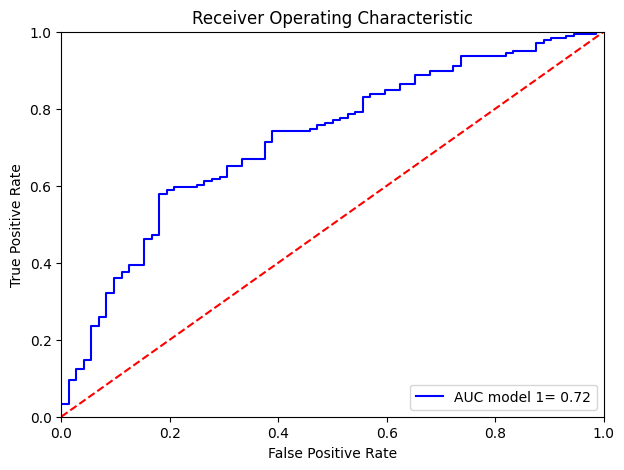

In [94]:
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, threshold1 = roc_curve(y_test, y_proba[:,1])
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=(7,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC model 1= %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

To better understand the concepts of micro- and macro-average, please refer to [this content](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

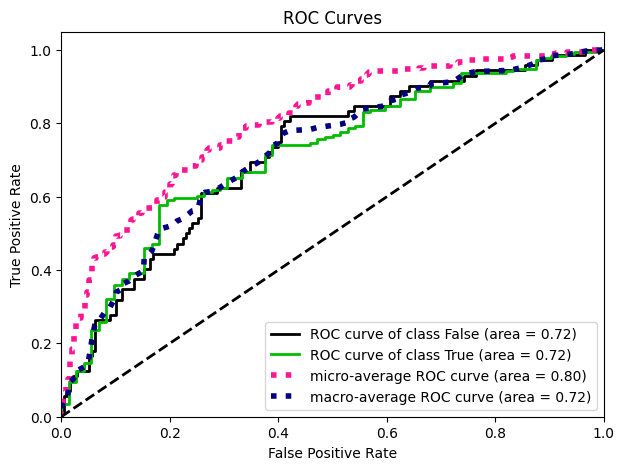

In [95]:
skplt.metrics.plot_roc(y_test, y_proba, figsize=(7,5))

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

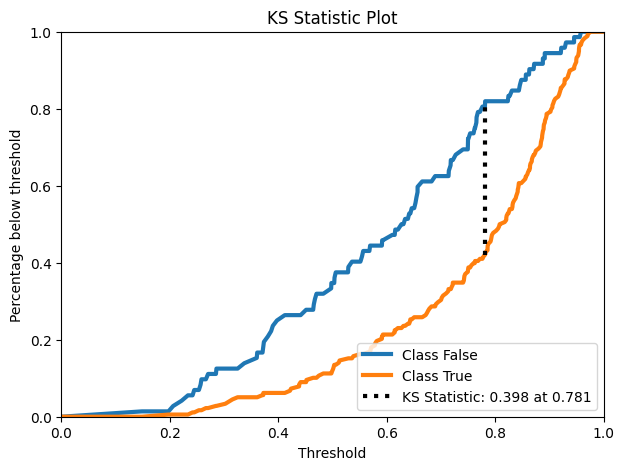

In [96]:
skplt.metrics.plot_ks_statistic(y_test, y_proba, figsize=(7,5))

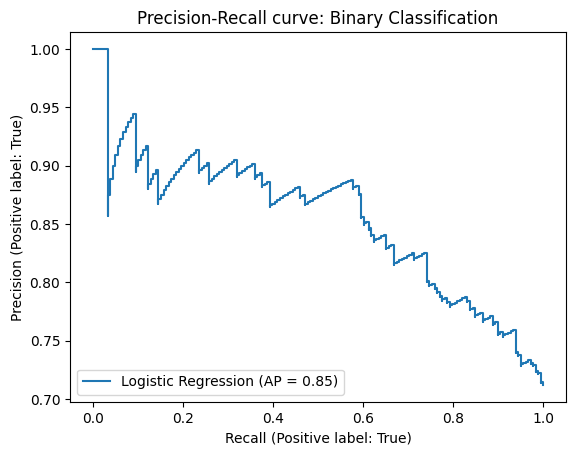

In [97]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="Logistic Regression")
_ = display.ax_.set_title("Precision-Recall curve: Binary Classification")

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

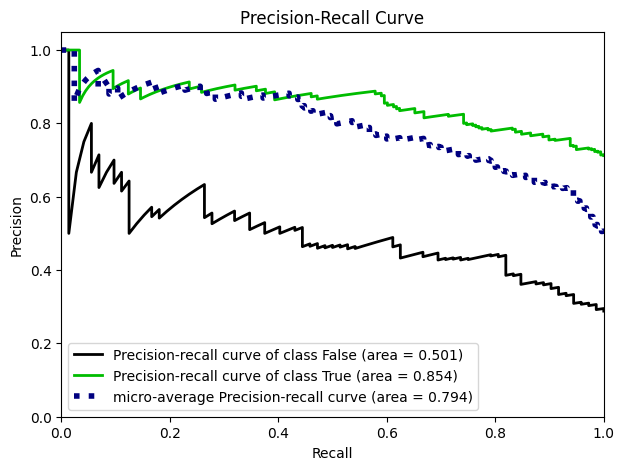

In [98]:
skplt.metrics.plot_precision_recall(y_test, y_proba, figsize=(7,5))

#### **Variable Importances**

In [99]:
# Get numerical feature importances
importances = np.absolute(model.coef_[0])

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Checking_account_little        Importance: 0.73
Variable: Checking_account_moderate      Importance: 0.61
Variable: Housing_own                    Importance: 0.3
Variable: Purpose_radio/TV               Importance: 0.28
Variable: Saving_accounts_little         Importance: 0.25
Variable: Housing_free                   Importance: 0.22
Variable: Purpose_furniture/equipment    Importance: 0.21
Variable: Sex_male                       Importance: 0.2
Variable: Purpose_education              Importance: 0.15
Variable: Saving_accounts_moderate       Importance: 0.14
Variable: Saving_accounts_rich           Importance: 0.14
Variable: Housing_rent                   Importance: 0.13
Variable: Saving_accounts_quite rich     Importance: 0.1
Variable: Purpose_repairs                Importance: 0.06
Variable: Purpose_domestic appliances    Importance: 0.04
Variable: Purpose_vacation/others        Importance: 0.04
Variable: Age                            Importance: 0.02
Variable: Purpose

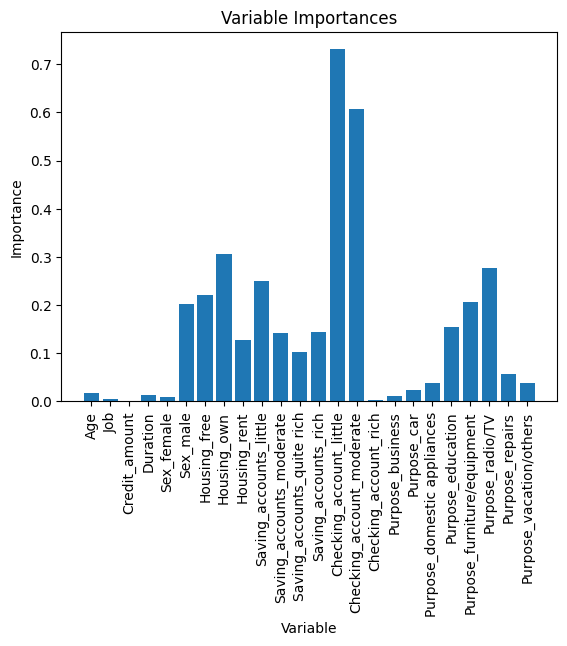

In [100]:
import matplotlib.pyplot as plt

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Experimenting a k-fold cross-validation approach.

In [101]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# define model
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter = 1000)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean Accuracy: %.3f' % mean(scores))

Mean Accuracy: 0.736


In [102]:
scores

array([0.74666667, 0.70666667, 0.74666667, 0.74666667, 0.74666667,
       0.72      , 0.72      , 0.8       , 0.69333333, 0.78666667,
       0.76      , 0.72      , 0.66666667, 0.76      , 0.81333333,
       0.74666667, 0.74666667, 0.68      , 0.69333333, 0.69333333,
       0.76      , 0.73333333, 0.69333333, 0.73333333, 0.73333333,
       0.78666667, 0.76      , 0.72      , 0.77333333, 0.70666667])

<font color="green">
Atividade (a) <br>
Por que a medida de acurácia apresentada ao se executar esta última célula do notebook (a célula acima), é considerada mais robusta que a medida de acurácia fornecida anteriormente?<br>
</font>

Resposta:<br>
O caso ideal seria a comparação entre diferentes abordagens (hold-out e cross validation), entretanto não é o que ocorre. Assim sendo, a acurácia obtida no início do notebook é mais adequada porque incorpora um processo de Cross Validation juntamente com uma busca pelo parâmetro "class_weight" que melhor performa na classificação. Ademais, vale ressaltar que é possível melhorar ainda mais a acurácia ao buscar pelo melhor parâmetro "c" que é aplicado na regualarização - processo adicionalmente implementado no primeiro cômputo de acurácia.

<font color="green">
Atividade (b) <br>
De acordo com o teste KS (Kolmogorov-Smirnov), qual é o limiar recomendado para a separação entre as classes? O que acontece quando se adota esse limiar?<br>
</font>

Resposta: <br>
O limiar é 0,781. Quando esse limiar é adotado, obtem-se máximo desempenho na tarefa de classificação, pois é o valor que implica na melhor separação das classes (maior distância entre as funções de distribuição acumulada).

<font color="green">
Atividade (c) <br>
Quais são as três variáveis independentes mais importantes para o processo de classificação de risco de crédito, ao se usar um modelo logístico? Como se chegou a elas?<br>
</font>

Resposta:<br>
1st: Checking_account_little: (0.73);
<br>2nd: Checking_account_moderate: (0.61);
<br>3rd: Housing_own: (0.3);
<br>Chega-se a essa conclusão ao observar os pesos atribuidos pelo classificador. Os três maiores pesos, como obtidos nas células acima, são esses que esta resposta versa entre parênteses associados ao respectivo nome da feature.